In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (12,6)
legend_fontsize = 16

# from matplotlib import rc
# rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
# rc('figure', **{'dpi': 200})

## Полиномиальная регрессия и оверфиттинг

In [2]:
## Оверфиттинг
## Исходная функция
orig = lambda x : np.sin(2*x)

## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = orig(xd) + np.random.normal(0, .25, num_points)

## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

## Обучаем модель с регуляризацией
def train_model(xs, ys, alpha=0, use_lasso=False):
    if alpha == 0:
        return linear_model.LinearRegression(fit_intercept=True).fit( xs, ys )
    else:
        if use_lasso:
            return linear_model.Lasso(alpha=alpha, fit_intercept=True).fit( xs, ys )
        else:
            return linear_model.Ridge(alpha=alpha, fit_intercept=True).fit( xs, ys )

[0.15495814]


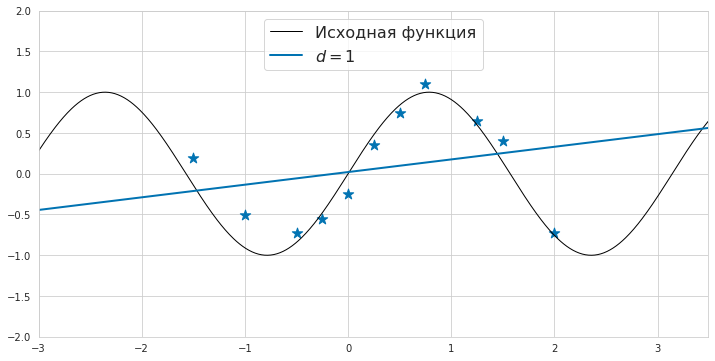

In [3]:
## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d = np.vstack([xd ** i for i in range(1, num_points+1)]).transpose()

## Какие степени многочлена будем обучать и рисовать
set_of_powers = [ 1 ]
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for d in set_of_powers:
    if d == 0:
        print(np.mean(data))
        ax.hlines(np.mean(data), xmin=xs[0], xmax=xs[-1], label="$d=0$", linestyle="dashed")
    else:
        cur_model = train_model( xd_d[:, :d], data )
        print(cur_model.coef_)
        ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="upper center", fontsize=legend_fontsize)

plt.show()

# Байесовские предсказания в линейной регрессии

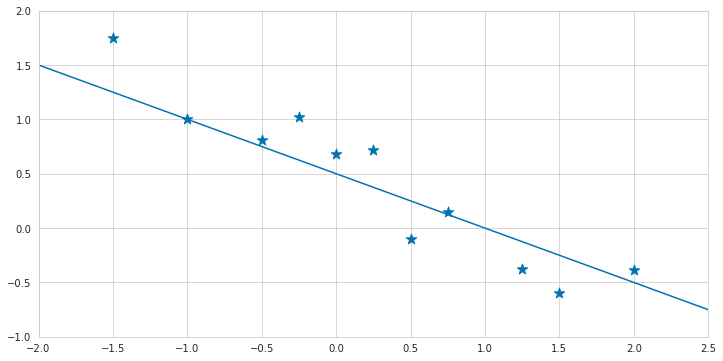

In [4]:
## Исходная функция
N = 250
true_mu = [.5, -.5]
def true_curve(x):
    return true_mu[0] + true_mu[1]*x


## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = true_curve(xd) + np.random.normal(0, .25, num_points)

## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xd[0]-.5, xd[-1]+.5))
ax.set_ylim((-1, 2))
ax.plot(xs, true_curve(xs))
ax.scatter(xd, data, marker='*', s=120)
plt.show()

In [5]:
xs = np.linspace(-3, 3, N)
X = np.linspace(-1, 1, N)
Y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.scatter(true_mu[0], true_mu[1], marker='*', s=120)

(250, 250)


/tmp/ipykernel_67622/2836965086.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


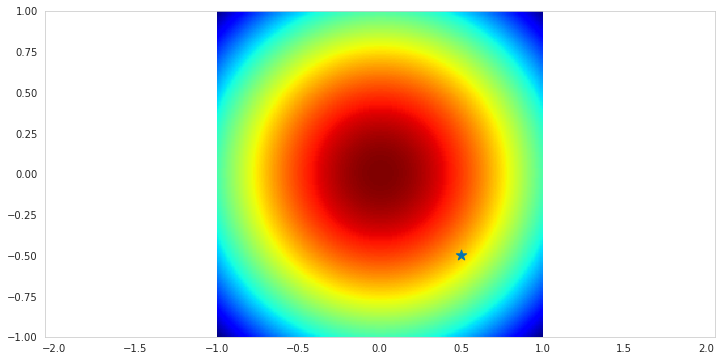

In [6]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

In [7]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
    plt.ylim((-3, 3))
    plt.xlim((-3, 3))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

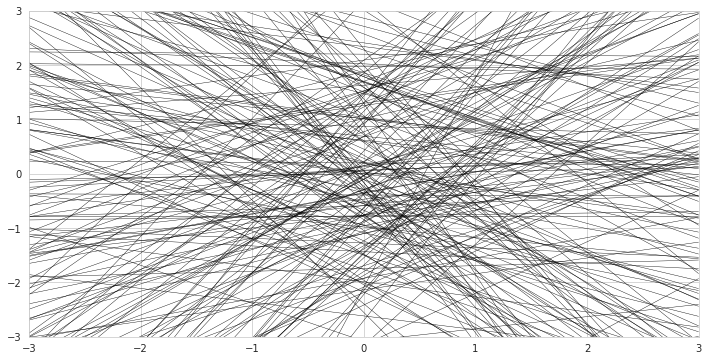

In [8]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_sample_lines(cur_mu, cur_sigma, 200)

/tmp/ipykernel_67622/2836965086.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


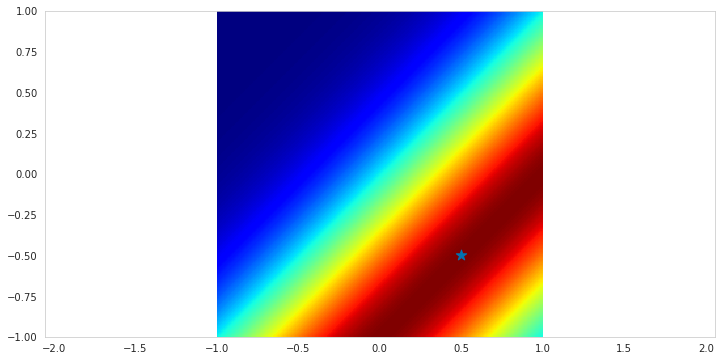

In [9]:
def get_likelihood(px, py, sigma=.5):
    return lambda x : np.exp(-(x[0] + x[1]*px - py) ** 2) / (2 * sigma * np.sqrt(2.*np.pi))

px, py = xd[1], data[1]
cur_likelihood = get_likelihood(px, py)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

In [10]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

/tmp/ipykernel_67622/2836965086.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


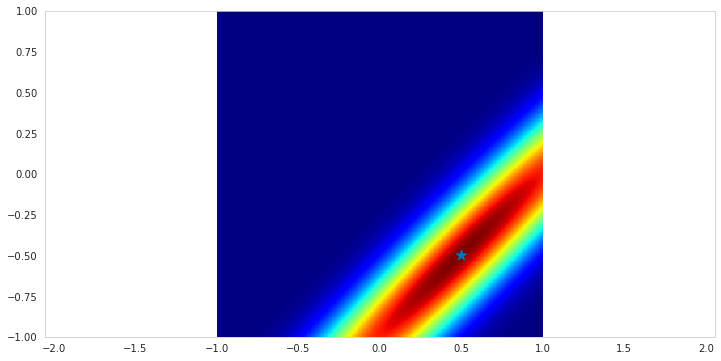

In [11]:
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

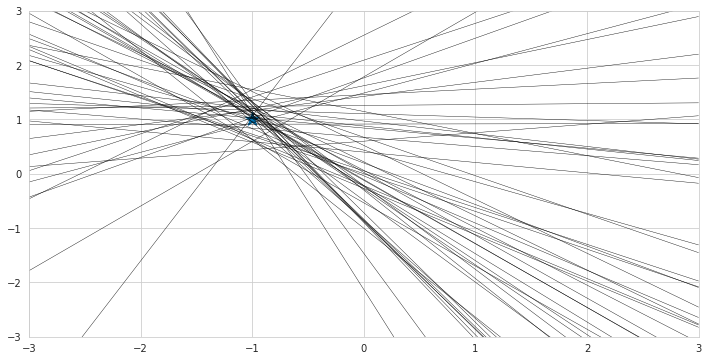

In [12]:
# Посэмплируем и порисуем прямые
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_sample_lines(cur_mu, cur_sigma, 50, points=[[px], [py]])

In [13]:
# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [14]:
# Нарисуем результат
def plot_predictions(xs, mu, x, points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 2))
    ax.plot(xs, true_curve(xs), label="Правильный ответ")
    ax.plot(xs, mu[1]*xs + mu[0], color="red", label="MAP гипотеза")
    ax.fill_between(xs, mu[1]*xs + mu[0] - .25, mu[1]*xs + mu[0] + .25, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

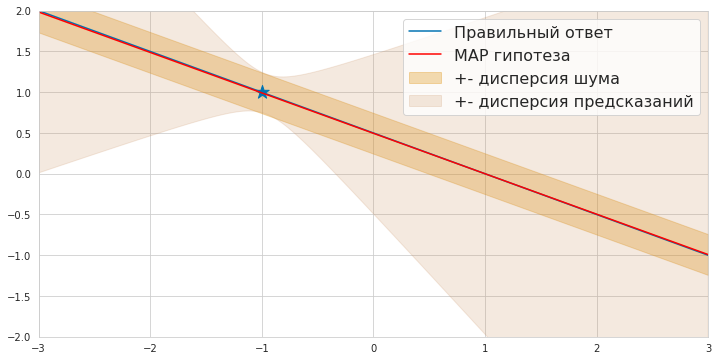

In [15]:
x = sample_statistics(cur_mu, cur_sigma, xs, n=1000)
plot_predictions(xs, cur_mu, x, [[px], [py]])

/tmp/ipykernel_67622/2836965086.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


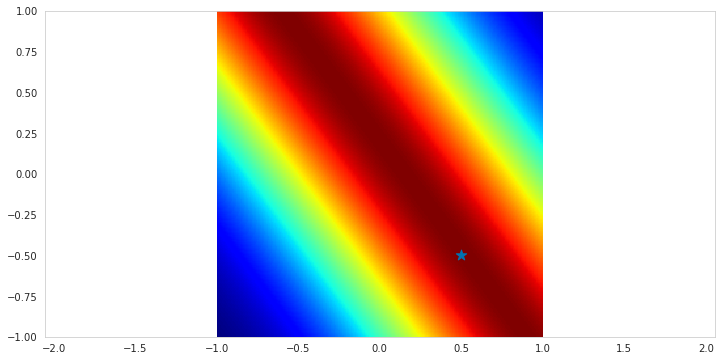

In [16]:
px2, py2 = xd[7], data[7]
cur_likelihood = get_likelihood(px2, py2)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

/tmp/ipykernel_67622/2836965086.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


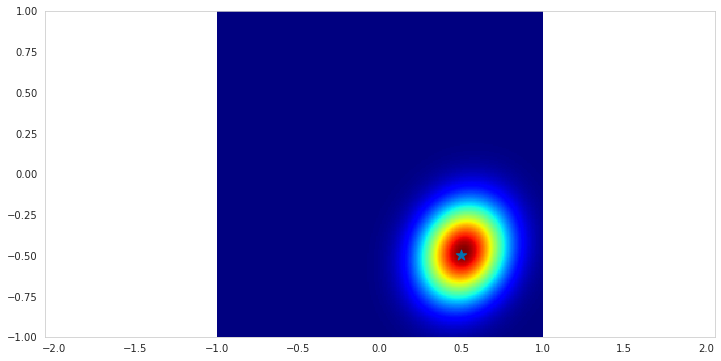

In [17]:
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px2, py2)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

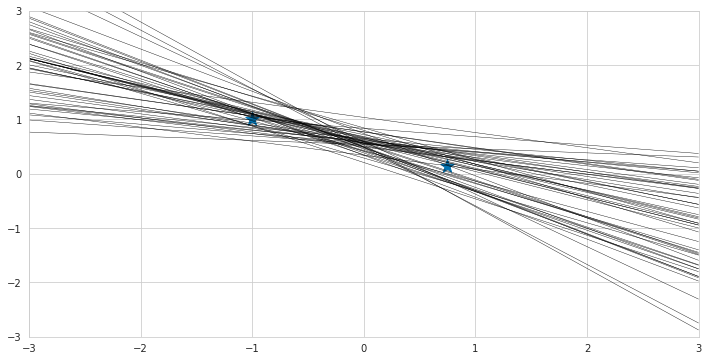

In [18]:
# Посэмплируем и порисуем прямые
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_sample_lines(cur_mu, cur_sigma, n=50, points=[[px, px2], [py, py2]])

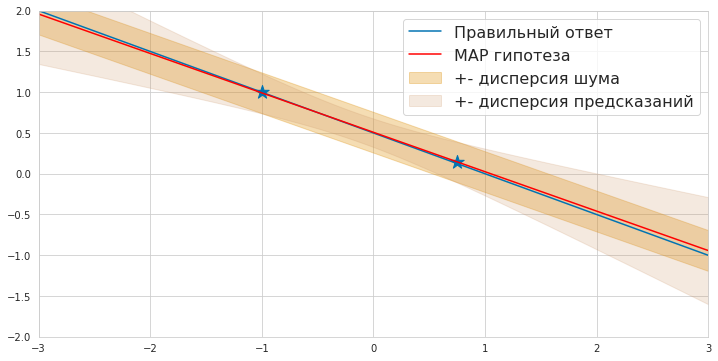

In [19]:
x = sample_statistics(cur_mu, cur_sigma, xs, n=2000)
plot_predictions(xs, cur_mu, x, [[px, px2], [py, py2]])

/tmp/ipykernel_67622/2836965086.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


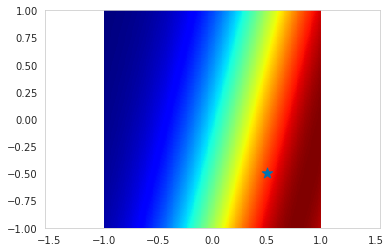

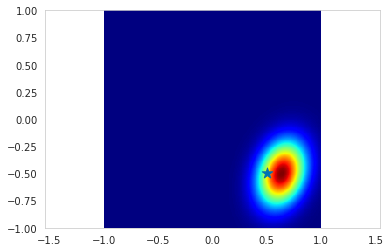

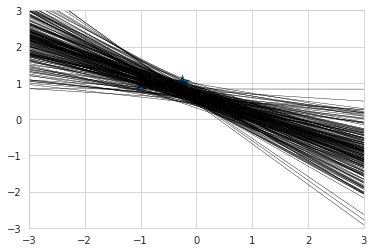

In [20]:
px3, py3 = xd[3], data[3]
cur_likelihood = get_likelihood(px3, py3)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])
myplot_heatmap(Z)
plt.show()
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px3, py3)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z)
plt.show()
myplot_sample_lines(cur_mu, cur_sigma, n=200, points=[[px, px2, px3], [py, py2, py3]])
plt.show()

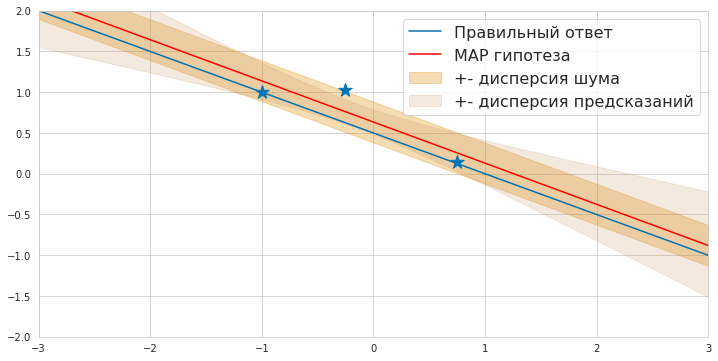

In [21]:
x = sample_statistics(cur_mu, cur_sigma, xs, n=2000)
plot_predictions(xs, cur_mu, x, [[px, px2, px3], [py, py2, py3]])

## Проклятие размерности

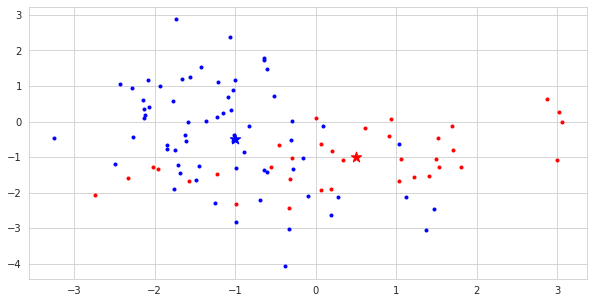

In [22]:
figsize = (10, 5)
def sample_mixture(N, pi, mu1, sigma1, mu2, sigma2):
    z = np.array( np.random.rand(N) < pi, dtype=int)
    res = np.zeros((N, 2))
    res[np.where(z == 1)] = np.random.multivariate_normal(mu1, sigma1, np.sum(z))
    res[np.where(z == 0)] = np.random.multivariate_normal(mu2, sigma2, N-np.sum(z))
    return z, res

def plot_points(ax, x, z, mu1, mu2):
    ax.scatter(x[np.where(z==1), 0], x[np.where(z==1), 1], marker='.', color='b')
    ax.scatter(x[np.where(z==0), 0], x[np.where(z==0), 1], marker='.', color='r')
    ax.scatter([mu1[0]], [mu1[1]], marker='*', s=120, color='b')
    ax.scatter([mu2[0]], [mu2[1]], marker='*', s=120, color='r')


mu1, sigma1 = np.array([-1, -.5]), np.array([[1, -.5], [-.5, 2]])
mu2, sigma2 = np.array([.5, -1]), np.array([[2, .5], [.5, .5]])
z, x = sample_mixture(100, 0.7, mu1, sigma1, mu2, sigma2)
test_z, test_x = sample_mixture(100, 0.7, mu1, sigma1, mu2, sigma2)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plot_points(ax, x, z, mu1, mu2)

In [23]:
from matplotlib import colors
colorfrac = 0.3
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, colorfrac, colorfrac)],
     'green': [(0, colorfrac, colorfrac), (1, colorfrac, colorfrac)],
     'blue': [(0, colorfrac, colorfrac), (1, 1, 1)]})

def plot_colormesh(ax, model):
    nx, ny = 100, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap,
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=1.5, colors='white')    
#     plt.contour(xx, yy, Z, [0.2, 0.4, 0.6, 0.8], linewidths=.8, colors='white')    

/tmp/ipykernel_67622/4182033369.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap,


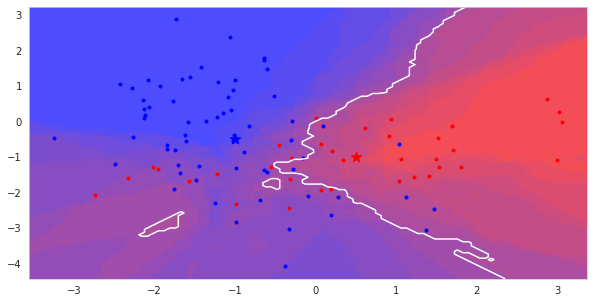

In [24]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=15).fit(x, z)
z_nn = neigh.predict(x)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plot_points(ax, x, z, mu1, mu2)
plot_colormesh(ax, neigh)
plt.show()